### Project 3

## Credit card fraud detection

#### Problem Statement

Credit card fraud has become a pervasive issue, causing significant financial losses to businesses and consumers alike. Traditional fraud detection methods are no longer sufficient to combat increasingly sophisticated fraudulent activities. There is an urgent need for a robust system that can accurately detect and prevent fraudulent transactions in real-time to safeguard financial transactions and mitigate losses.

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

import warnings
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

RANDOM_STATE = 2018

### Data gathering

This dataset contains the real bank transactions made by European cardholders in the year 2013. As a security concern, the actual variables are not being shared but — they have been transformed versions of PCA. As a result, we can find 29 feature columns and 1 final class column.

In [2]:
df_train = pd.read_csv('C:/Users/Lenovo/Downloads/train.csv')
df_test = pd.read_csv('C:/Users/Lenovo/Downloads/test.csv')

In [3]:
df_train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [4]:
df_test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219129 entries, 0 to 219128
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      219129 non-null  int64  
 1   Time    219129 non-null  float64
 2   V1      219129 non-null  float64
 3   V2      219129 non-null  float64
 4   V3      219129 non-null  float64
 5   V4      219129 non-null  float64
 6   V5      219129 non-null  float64
 7   V6      219129 non-null  float64
 8   V7      219129 non-null  float64
 9   V8      219129 non-null  float64
 10  V9      219129 non-null  float64
 11  V10     219129 non-null  float64
 12  V11     219129 non-null  float64
 13  V12     219129 non-null  float64
 14  V13     219129 non-null  float64
 15  V14     219129 non-null  float64
 16  V15     219129 non-null  float64
 17  V16     219129 non-null  float64
 18  V17     219129 non-null  float64
 19  V18     219129 non-null  float64
 20  V19     219129 non-null  float64
 21  V20     21

In [6]:
df_train.shape

(219129, 32)

In [7]:
df_train.isnull().sum()

id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
df_train.drop(["id"], axis=1, inplace=True)

In [9]:
df_train.describe(percentiles=[0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,25%,50%,75%,95%,max
Time,219129.0,62377.415376,25620.348569,0.000000,47933.000000,63189.000000,77519.000000,113163.000000,120580.000000
V1,219129.0,0.096008,1.395425,-29.807725,-0.846135,0.385913,1.190661,1.914220,2.430494
V2,219129.0,0.048345,1.159805,-44.247914,-0.573728,0.046937,0.814145,1.532125,16.068473
V3,219129.0,0.592102,1.132884,-19.722872,-0.027154,0.735895,1.306110,2.173558,6.145578
V4,219129.0,0.069273,1.253125,-5.263650,-0.769256,0.064856,0.919353,2.176670,12.547997
V5,219129.0,-0.161555,1.069530,-37.591259,-0.847346,-0.229929,0.356856,1.881268,34.581260
V6,219129.0,0.133688,1.202411,-25.659750,-0.631835,-0.087778,0.482388,3.268870,16.233967
V7,219129.0,-0.128224,0.817207,-31.179799,-0.646730,-0.098970,0.385567,1.012358,39.824099
V8,219129.0,0.149534,0.716212,-28.903442,-0.095948,0.111219,0.390976,0.979161,18.270586
V9,219129.0,-0.048337,1.054143,-8.756951,-0.711444,-0.131323,0.583715,1.822600,13.423914


In [10]:
df_train.duplicated().sum() 

0

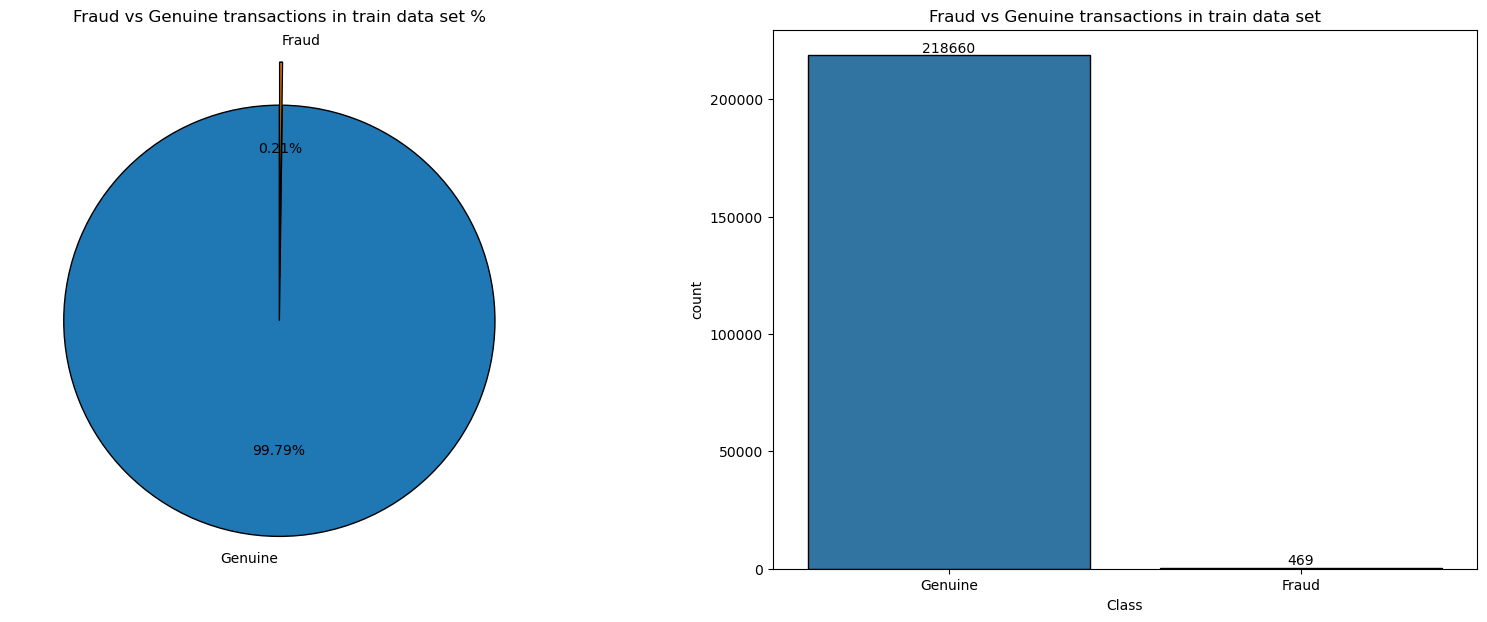

In [11]:
l1 = list(df_train['Class'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['Genuine','Fraud'], 
        autopct = '%1.2f%%',
        startangle = 90,
        explode = (0.1,0.1),
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Fraud vs Genuine transactions in train data set %');

plt.subplot(1,2,2)
ax = sns.countplot(data = df_train, 
                   x='Class',  
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
plt.title('Fraud vs Genuine transactions in train data set')
plt.show()

We observe that the number of fraudulent cases only make up 0.21% of the dataset, while the normal cases make up the rest (~99.79%) of the dataset.

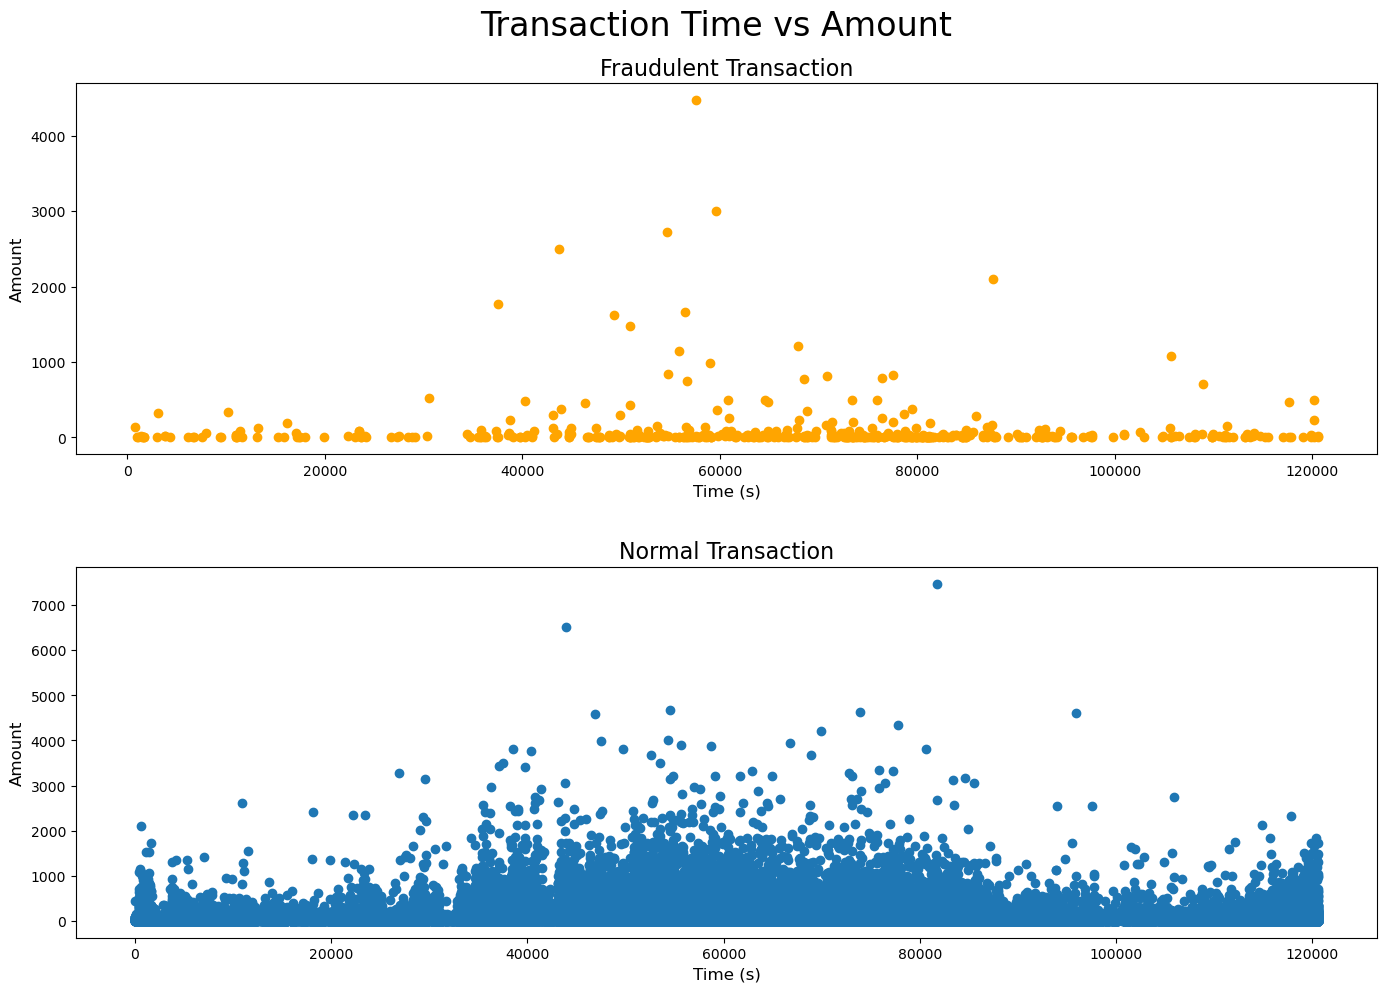

In [12]:
normal_samples = df_train.loc[df_train['Class'] == 0]
fraud_samples = df_train.loc[df_train['Class'] == 1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Transaction Time vs Amount', fontsize=24)
fig.tight_layout(pad=2.0, h_pad=6.0)

# Plot Fraudulent Samples
ax1.scatter(fraud_samples.Time, fraud_samples.Amount, c='orange')
ax1.set_title('Fraudulent Transaction', fontsize=16)
ax1.set_ylabel('Amount', fontsize=12)
ax1.set_xlabel('Time (s)', fontsize=12)

# Plot Normal Samples
ax2.scatter(normal_samples.Time, normal_samples.Amount)
ax2.set_title('Normal Transaction', fontsize=16)
ax2.set_ylabel('Amount', fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=12)

plt.show();

We see that the fraudulent transactions are associated with less amounts of money in comparison to normal transactions.

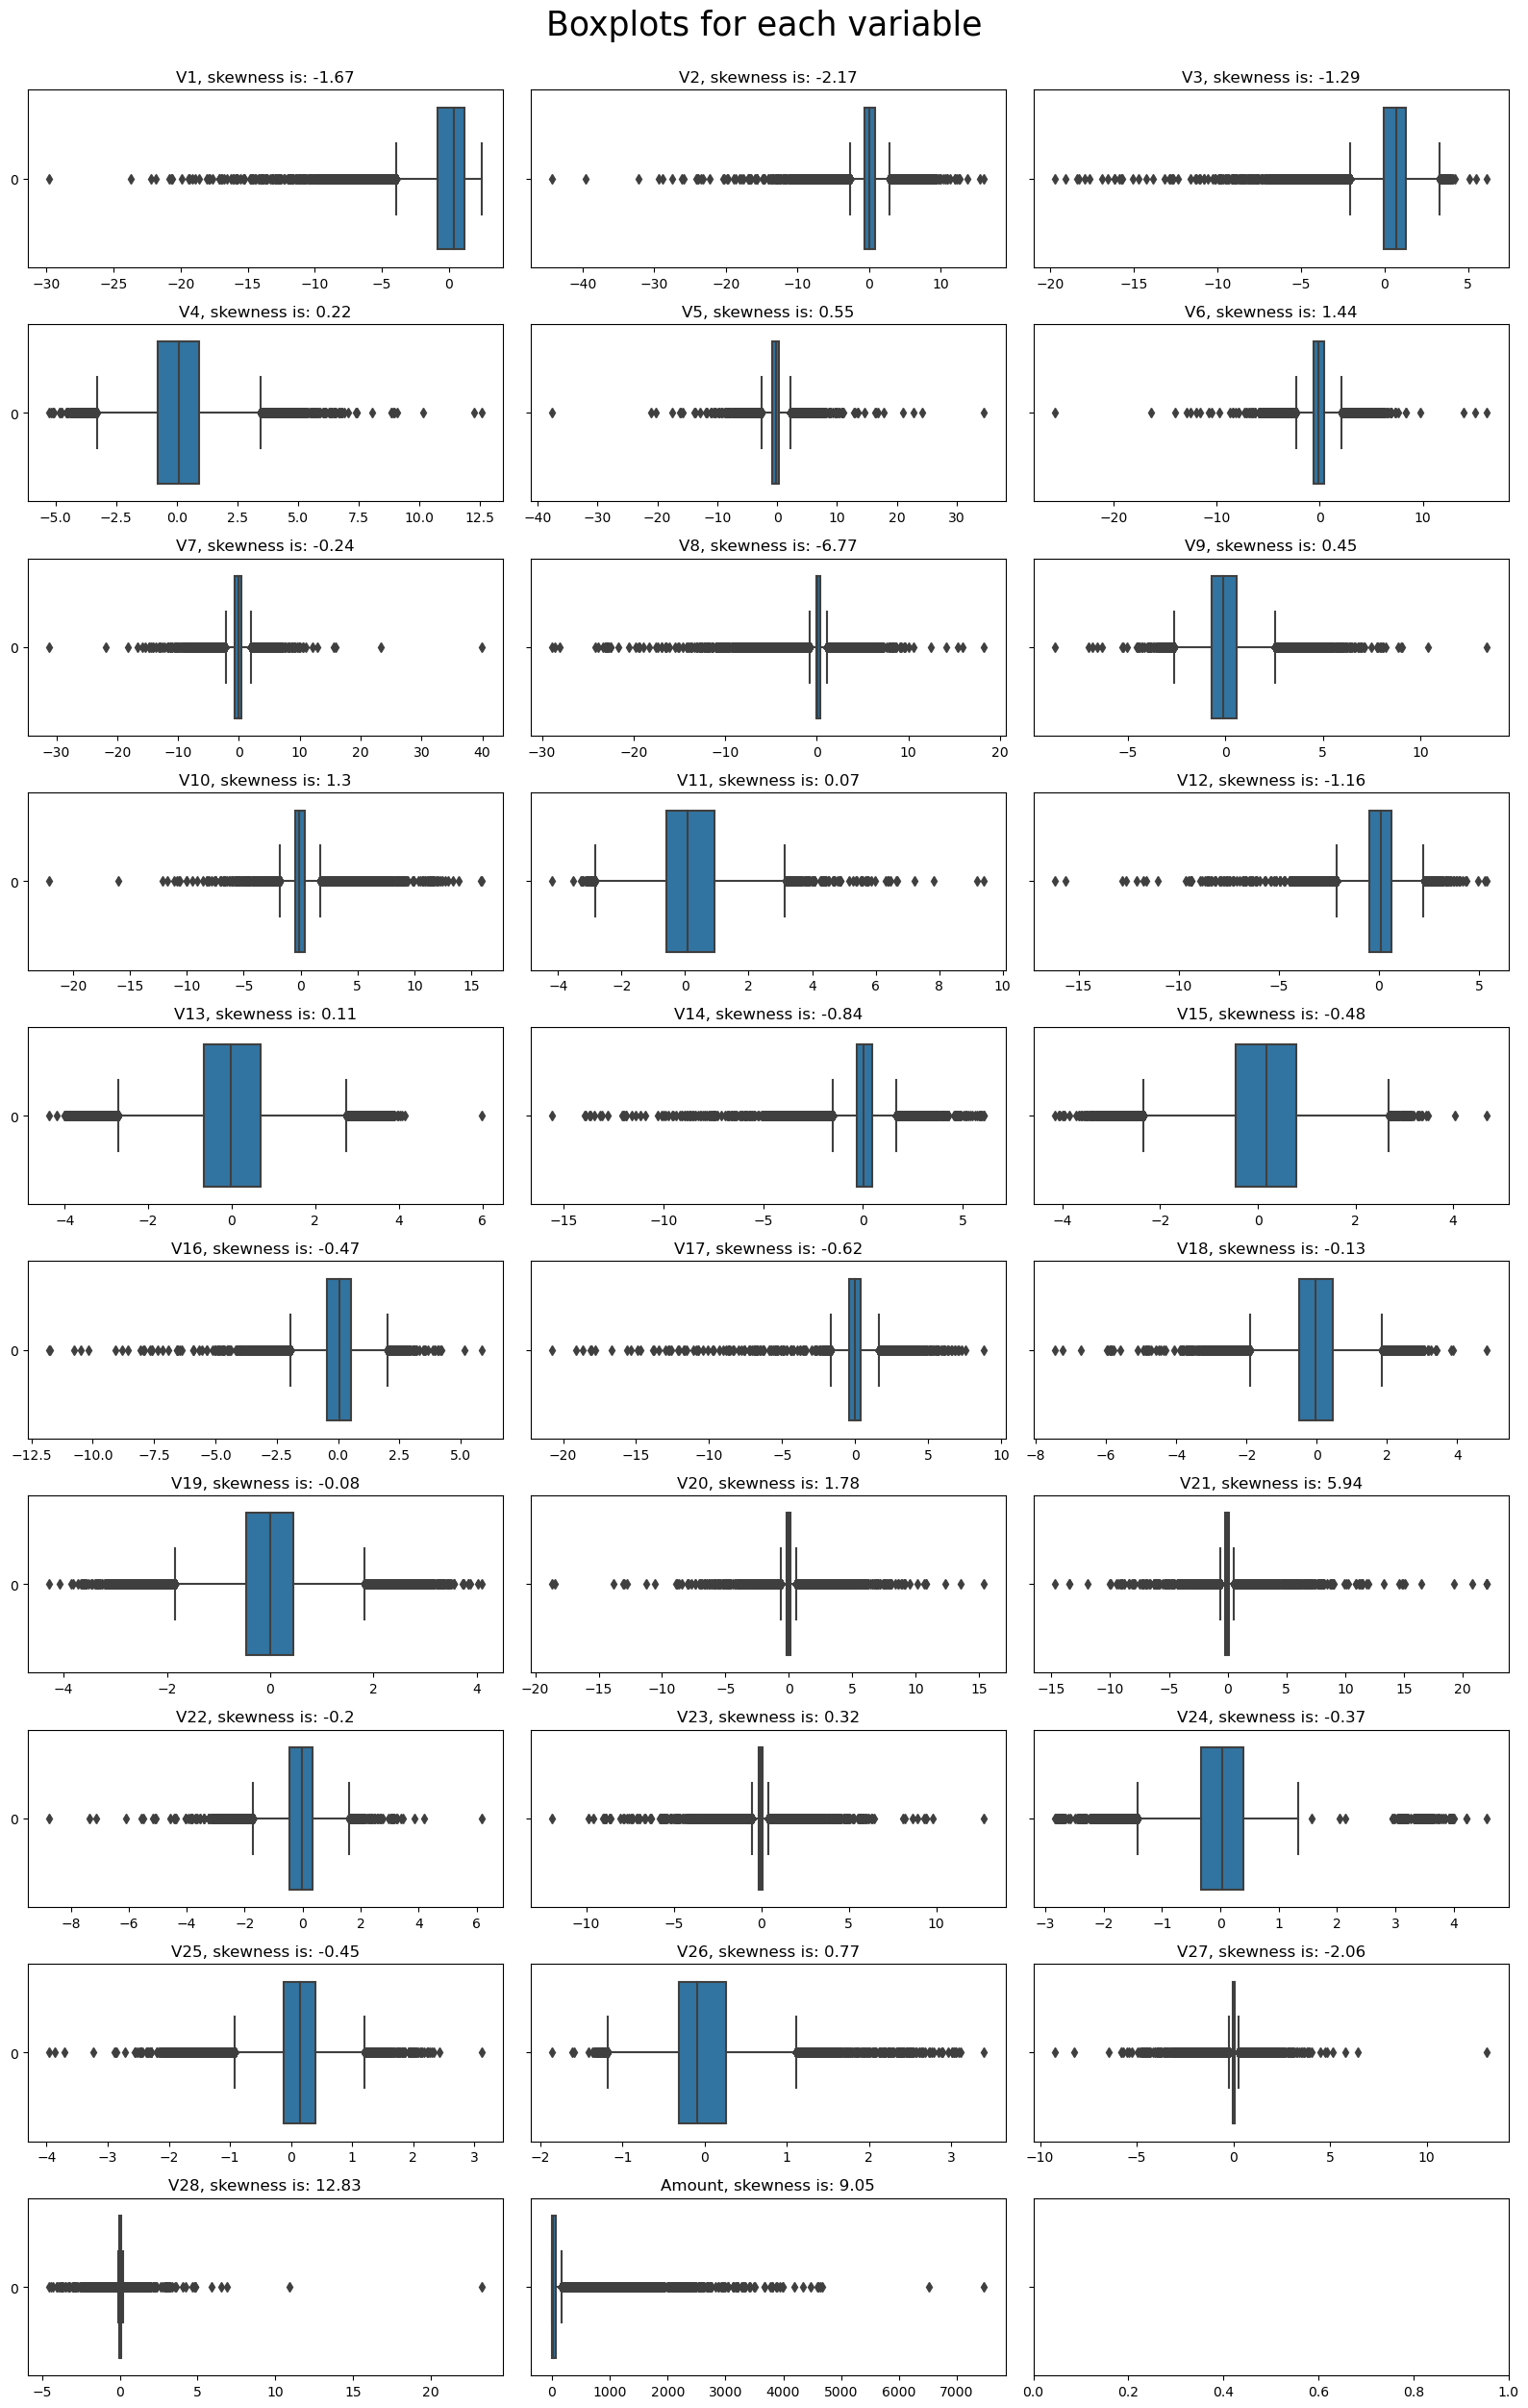

In [13]:
numeric_columns = (list(df_train.loc[:, 'V1':'Amount']))
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df_train, columns_list=numeric_columns, rows=10, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

In [14]:
feature_number = (df_train.columns.to_list())
len(feature_number)
feature_number

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

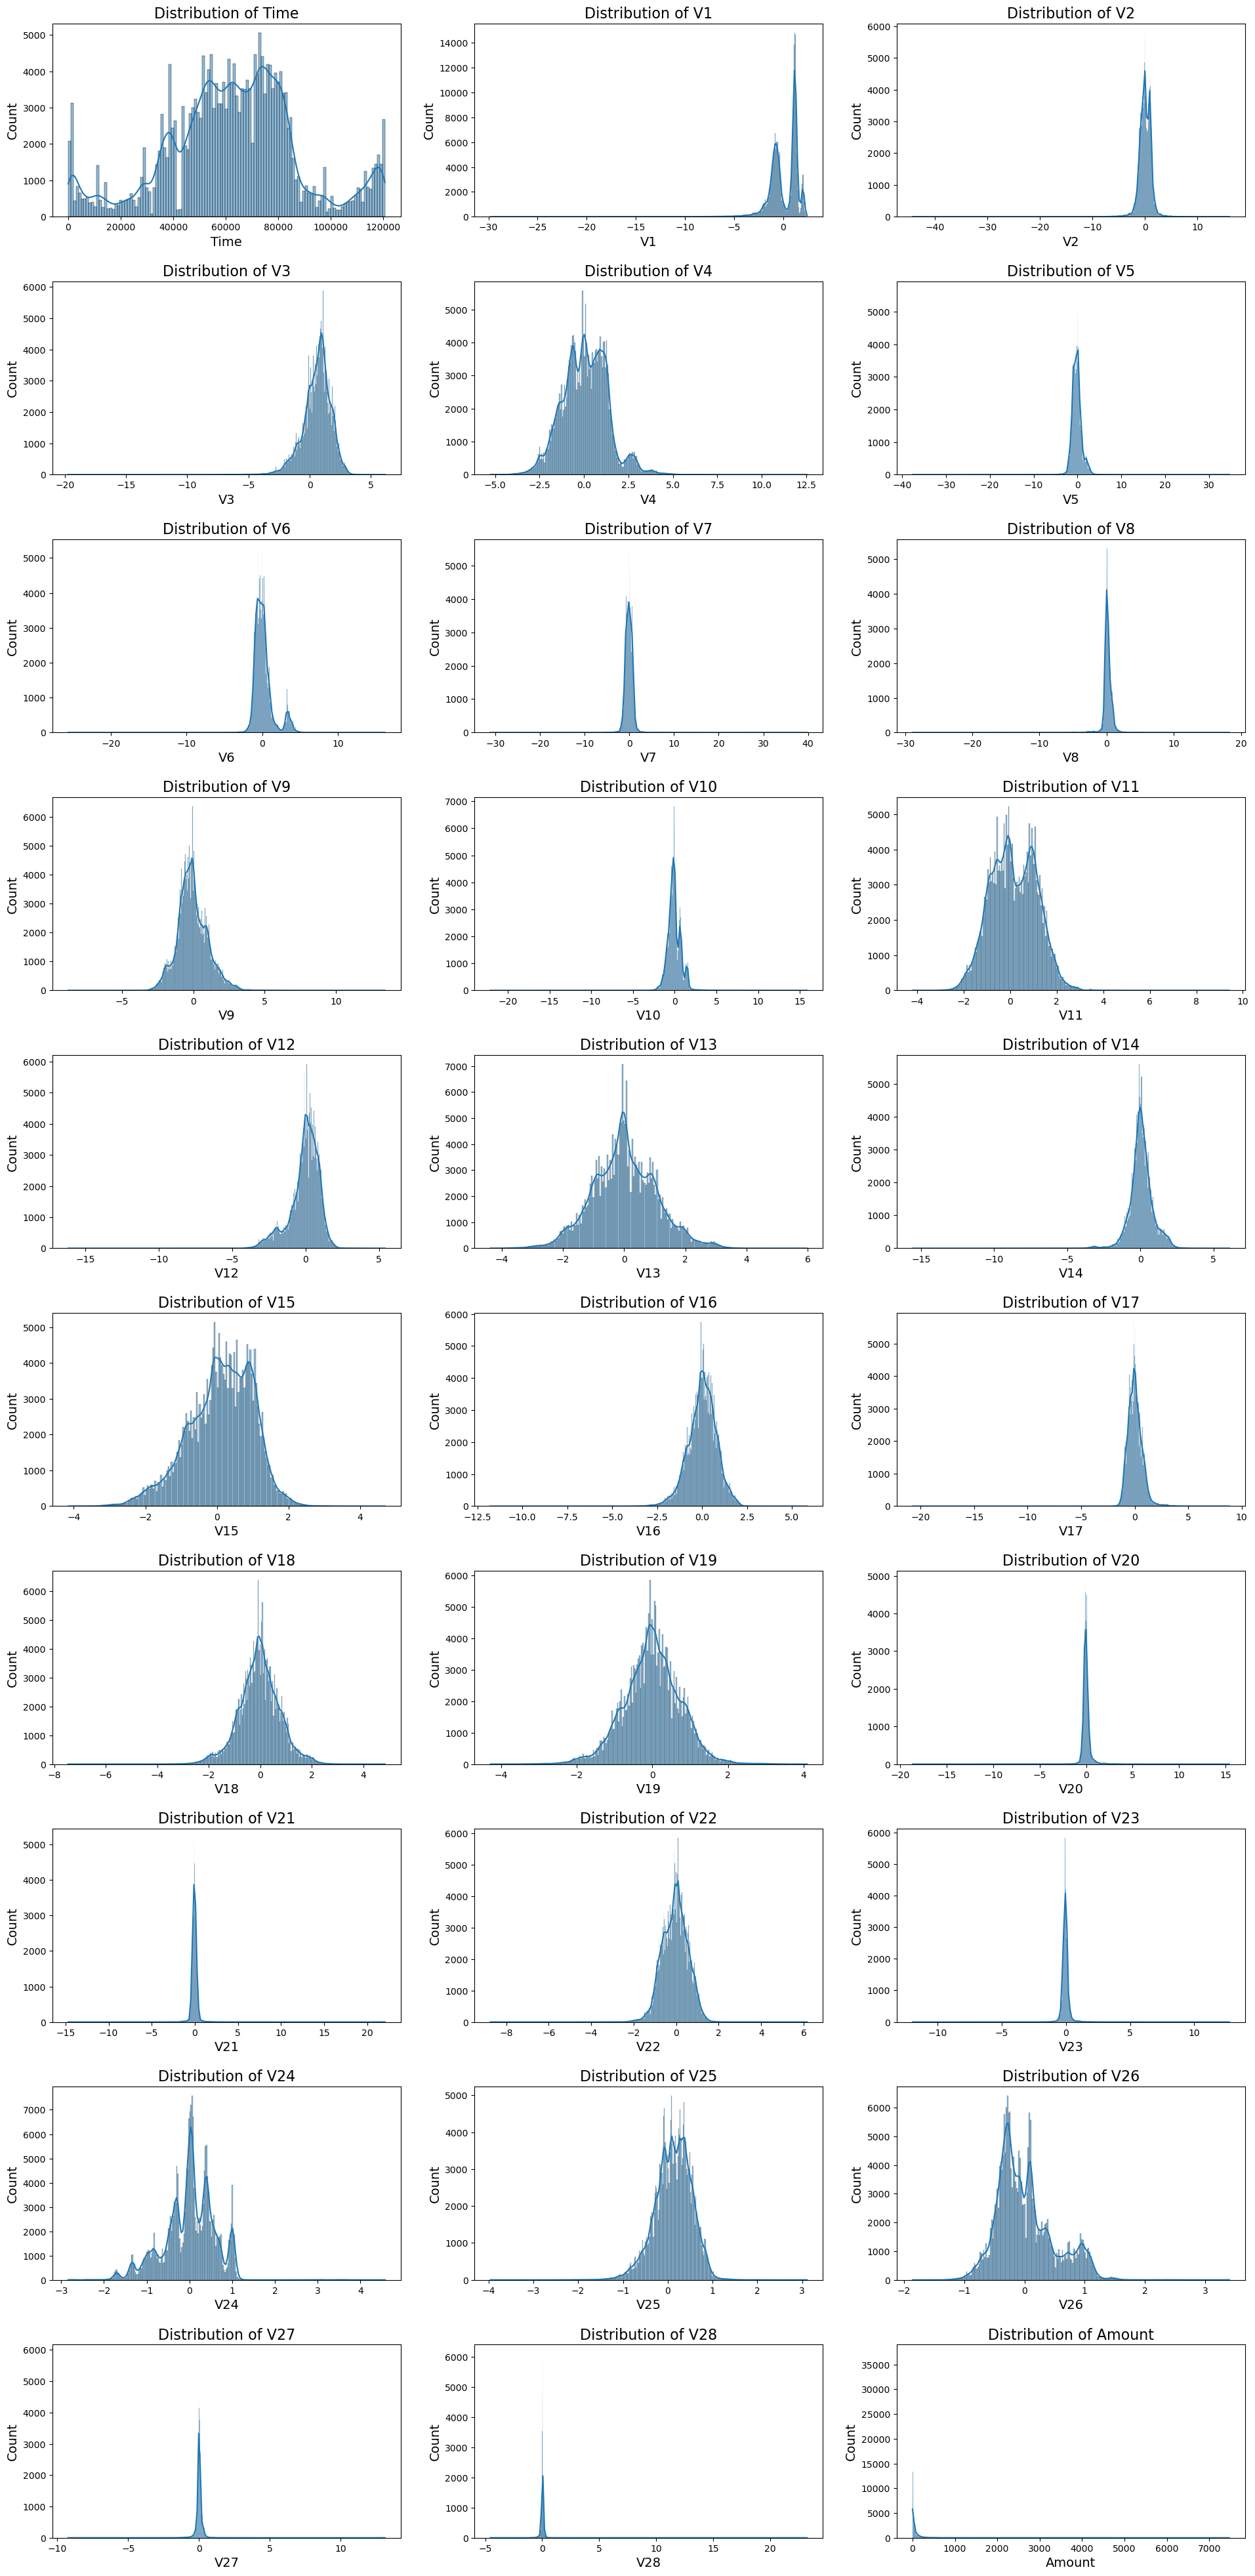

In [15]:
row,col = 10,3
fig,axis = plt.subplots(row, col, figsize=(20,40))
fig.tight_layout(pad=5.0)
col_num = 0
for i in range(row):
    for j in range(col):
        if(col_num > len(feature_number)-2):
            break
        sns.histplot(ax=axis[i,j], x=df_train[feature_number[col_num]], kde=True)
        axis[i,j].set_xlabel(feature_number[col_num], fontsize=14)
        axis[i,j].set_ylabel('Count', fontsize=14)
        axis[i,j].set_title(f'Distribution of { feature_number[col_num] }', fontsize=16)
        col_num += 1

In [16]:
df_train["day"] = (df_train["Time"]/ (3600 *24)).round(0)
df_train["hour"] = ((df_train["Time"]/3600)%24).round(0)

<AxesSubplot: xlabel='hour', ylabel='count'>

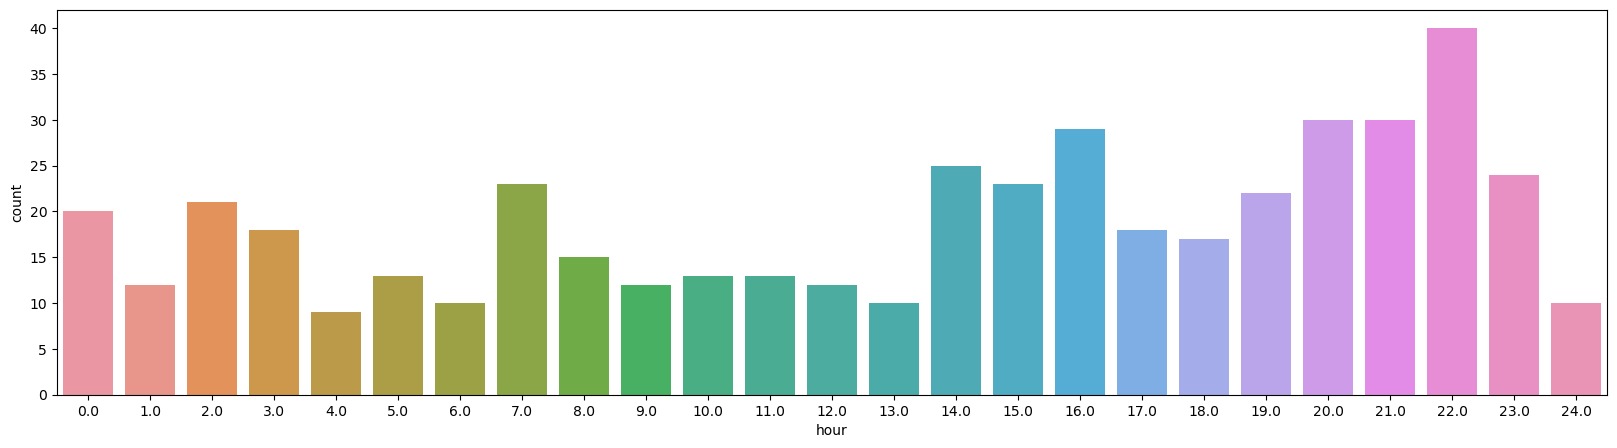

In [17]:
df_fraud = df_train[df_train["Class"] == 1]

fig,axis = plt.subplots(figsize=(20,5))
sns.countplot(x=df_fraud["hour"], ax=axis)

<AxesSubplot: >

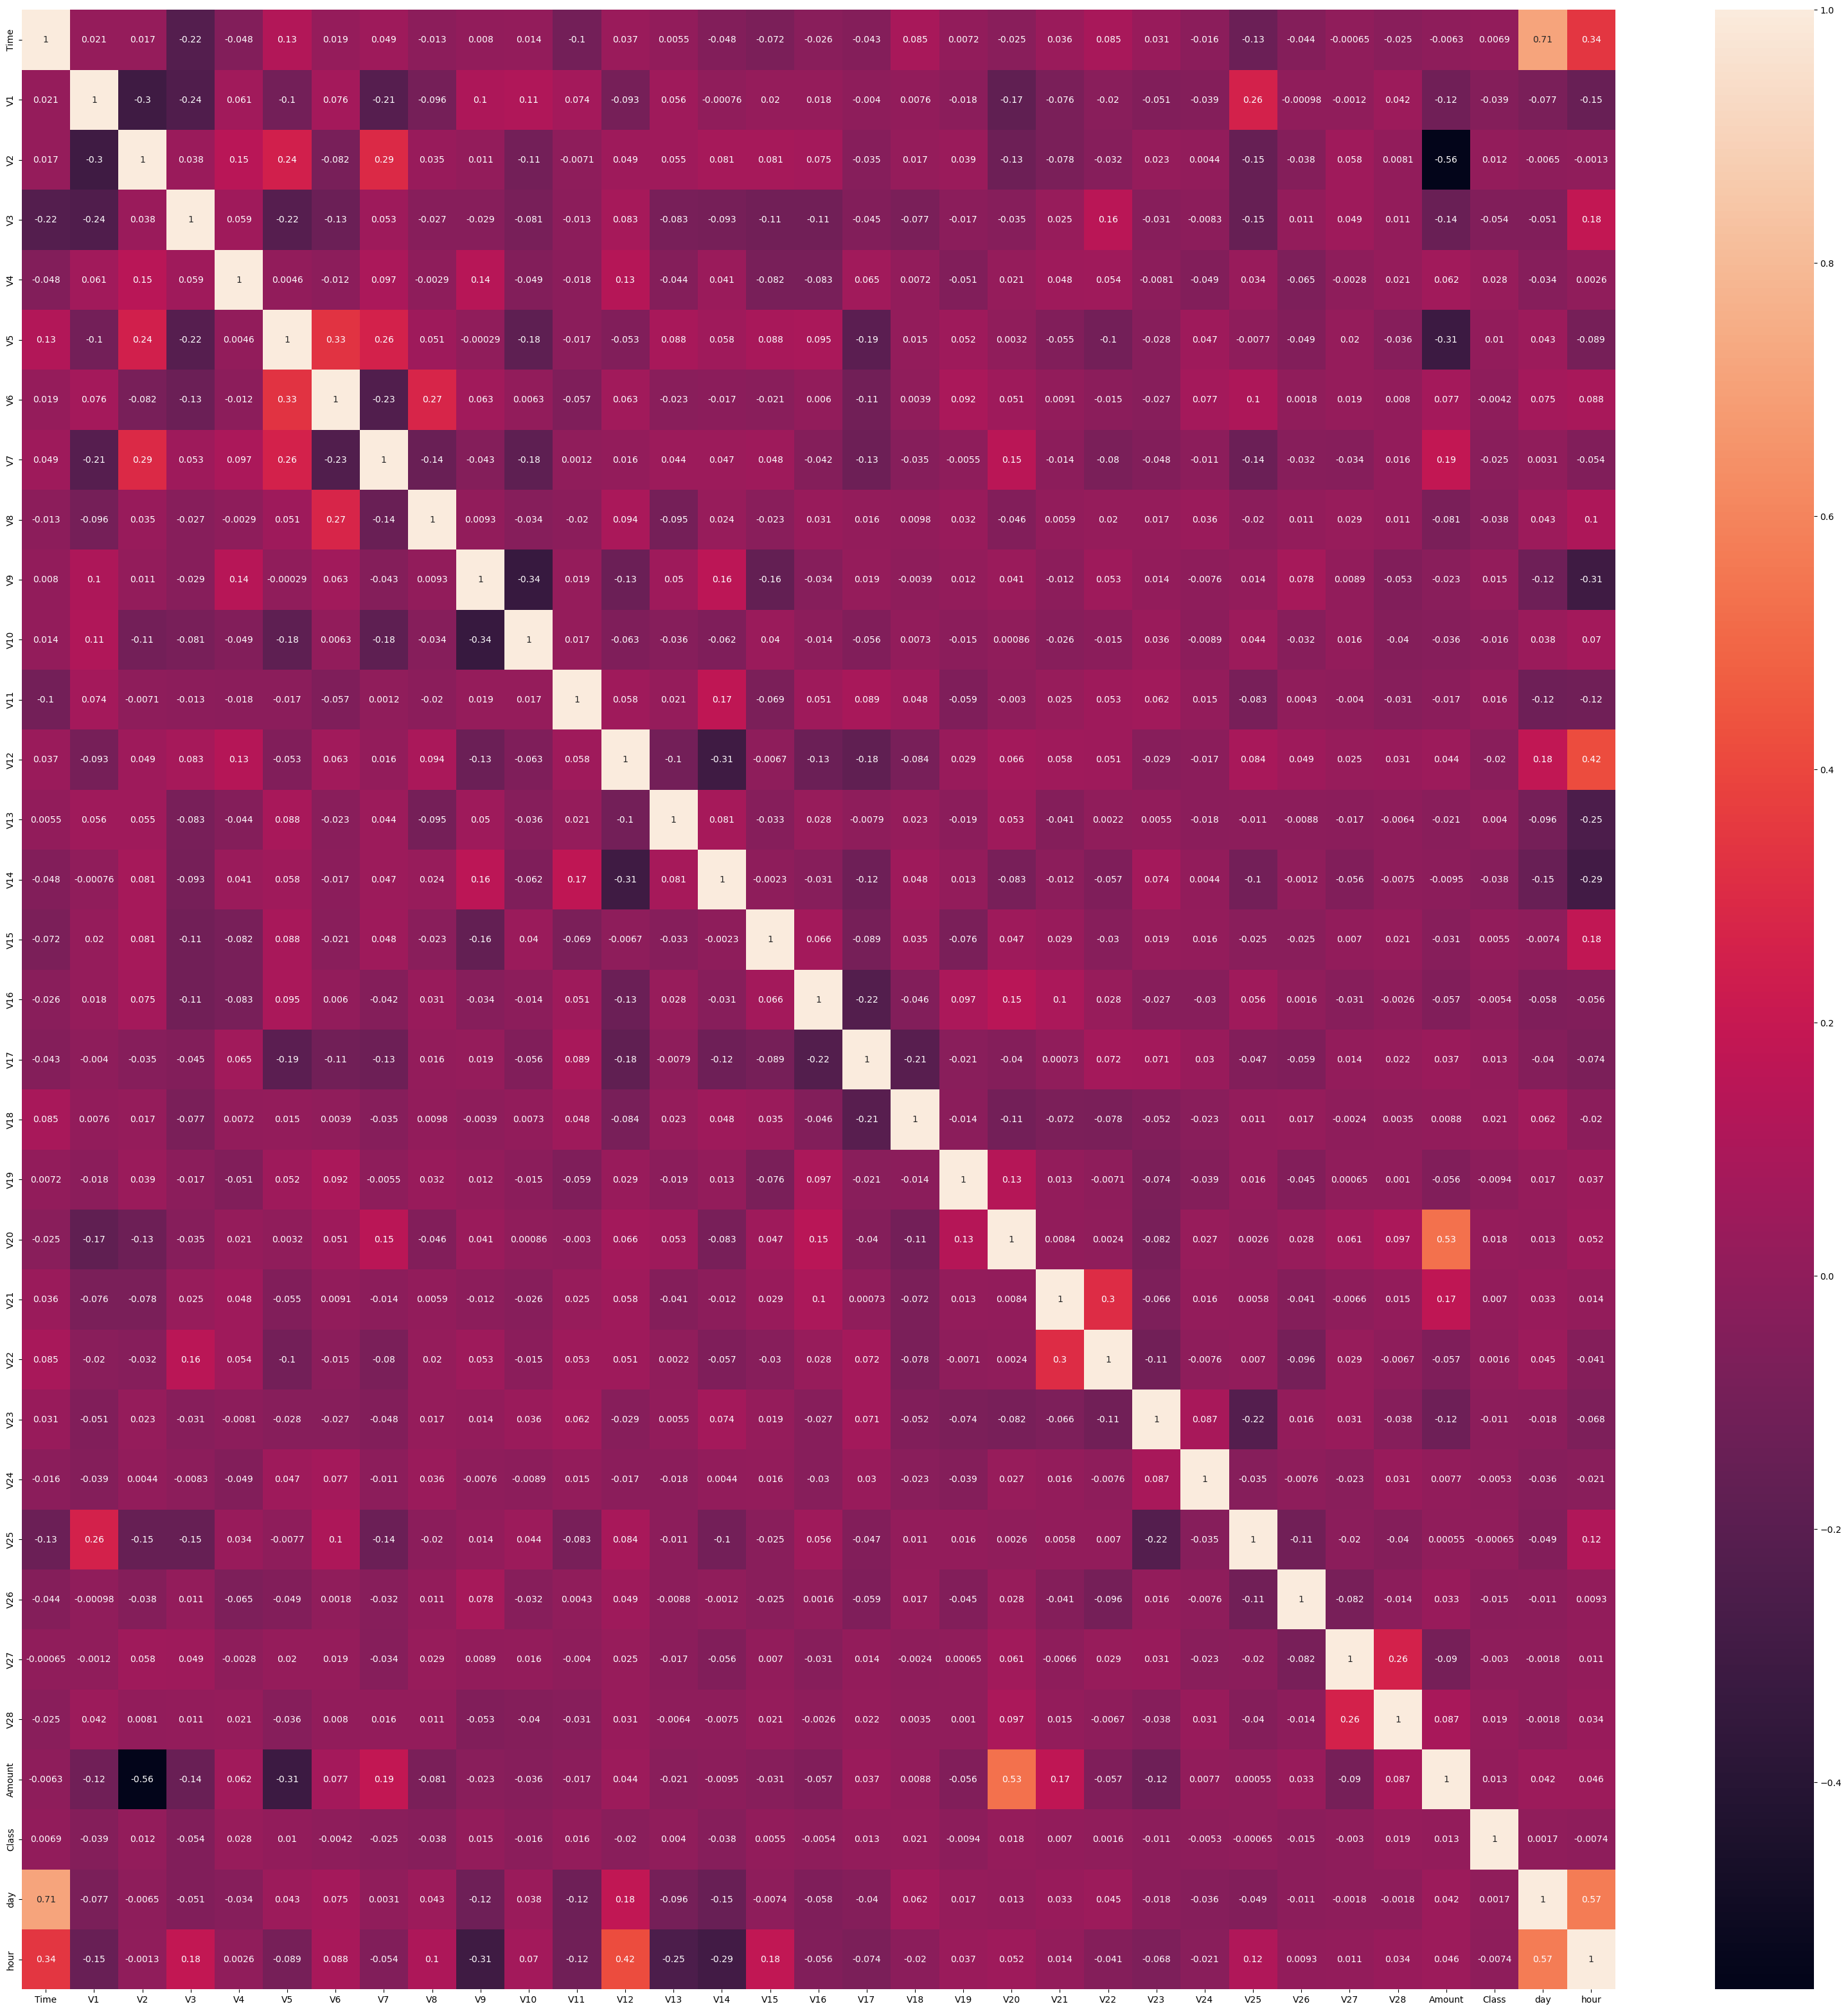

In [18]:
fig, axis= plt.subplots(figsize=(40,40))
sns.heatmap(df_train.corr(), annot=True, ax=axis)

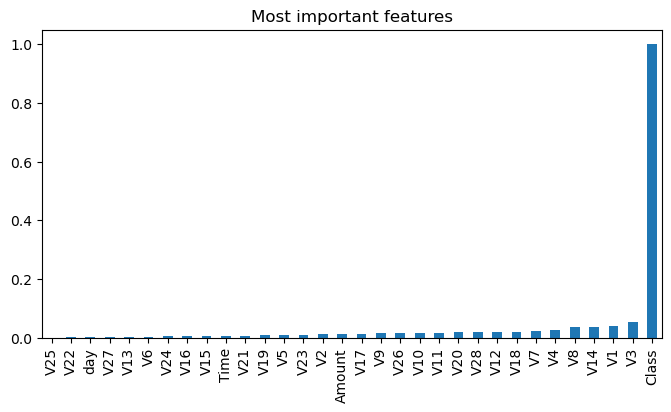

In [19]:
plt.figure(figsize=(8,4))
d = df_train.corr()['Class'][:-1].abs().sort_values().plot(kind='bar', title='Most important features')

plt.show()

In [20]:
def across_col_feat(df):

    features = [feat for feat in df.columns if 'V' in feat]
    df['V_Sum'] = df[features].sum(axis = 1)
    df['V_Min'] = df[features].min(axis = 1)
    df['V_Max'] = df[features].max(axis = 1)
    df['V_Avg'] = df[features].mean(axis = 1)
    df['V_Std'] = df[features].std(axis = 1)
    df['V_Var'] = df[features].var(axis = 1)
    
    return df
df_train = across_col_feat(df_train)
df_test  = across_col_feat(df_test)

In [21]:
X = df_train.drop(["Time","Class","id"], axis=1, errors="ignore")
y = df_train["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
weights = pd.DataFrame(compute_sample_weight('balanced', df_train['Class']), columns=['weight'])

#features to scale
scaleFeatures = X.columns.to_list()
rs = RobustScaler()
X[scaleFeatures] = rs.fit_transform(X[scaleFeatures])
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V28,Amount,day,hour,V_Sum,V_Min,V_Max,V_Avg,V_Std,V_Var
0,0.828957,-0.127074,-1.405058,0.206081,0.030967,-1.007308,0.203107,-0.769519,0.674409,0.237751,...,-1.068529,-0.316492,-1.0,-1.6,-0.917007,0.388817,0.458665,-0.917007,-0.360202,-0.329842
1,0.791888,-0.935120,-0.942697,-0.568157,-0.741237,-0.164319,-0.901212,-0.125319,0.016504,1.123157,...,-0.789575,0.986654,-1.0,-1.6,-0.619172,0.343888,0.370464,-0.619172,-0.044225,-0.043071
2,-0.144530,0.689963,-0.719543,-0.296164,0.745288,-0.808252,1.014356,-0.402544,0.068946,-0.788406,...,0.852209,-0.305211,-1.0,-1.6,-0.719784,0.633375,-0.791076,-0.719784,-0.749221,-0.632403
3,0.782472,-0.167080,-1.350146,0.032730,0.012200,-0.503536,0.010796,-0.301045,0.785356,0.109024,...,-1.254963,-0.332062,-1.0,-1.6,-0.409156,0.063891,0.348061,-0.409156,-0.387971,-0.353287
4,0.314211,-0.157625,0.350886,0.698234,-0.337687,1.065182,-0.813410,0.940641,0.636206,0.009450,...,-0.014546,-0.332062,-1.0,-1.6,0.829519,0.688176,-0.339126,0.829519,-0.382371,-0.348582


In [23]:
df_test 

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V26,V27,V28,Amount,V_Sum,V_Min,V_Max,V_Avg,V_Std,V_Var
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,-0.084889,0.004720,-0.021944,29.95,-1.389549,-2.243711,2.115519,-0.049627,0.921314,0.848819
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,0.068708,0.002629,0.064690,163.50,7.547428,-1.681429,3.703925,0.269551,1.147507,1.316773
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,-0.297813,0.043699,-0.037855,16.00,-3.662021,-1.682064,2.205568,-0.130786,0.902202,0.813969
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,-0.627529,-0.024338,-0.036143,120.98,-1.720208,-1.938259,2.079398,-0.061436,0.993326,0.986696
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,-0.025706,0.330758,0.335537,1.98,-6.427451,-2.037681,2.684779,-0.229552,0.928411,0.861946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146082,365211,172789.0,-0.661834,-0.622980,0.735580,-0.554067,0.869889,-0.389502,0.161226,0.069945,...,0.161938,0.149243,0.279708,94.81,-5.682672,-2.129855,0.869889,-0.202953,0.658588,0.433738
146083,365212,172789.0,-0.098889,0.761900,0.340012,-0.589546,0.717091,-0.262765,0.726272,-0.070608,...,-0.561426,0.326700,0.255166,24.99,3.138093,-1.130049,1.284819,0.112075,0.589375,0.347362
146084,365213,172789.0,-1.487918,1.769142,0.551671,0.361566,0.056347,0.084844,0.567545,-0.059899,...,-0.213933,0.392745,0.070938,29.99,8.409305,-1.487918,1.769142,0.300332,0.699404,0.489166
146085,365214,172790.0,-1.889979,-0.154869,0.068496,-1.906964,-1.743181,0.717490,0.981608,-0.209713,...,-0.204957,-0.752326,-0.155728,314.00,-7.898507,-1.906964,1.379725,-0.282090,0.903292,0.815936


In [24]:
X_test = df_test.drop(["id","Time"], axis=1, errors="ignore")
X_test["day"] = (df_test["Time"]/ (3600 *24)).round(0)
X_test["hour"] = ((df_test["Time"]/3600)%24).round(0)
X_test  = across_col_feat(X_test)
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V28,Amount,V_Sum,V_Min,V_Max,V_Avg,V_Std,V_Var,day,hour
0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,-0.230126,0.220610,...,-0.021944,29.95,-1.186785,-2.243711,2.115519,-0.028942,1.036428,1.081198,1.0,9.0
1,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,1.068183,0.483337,...,0.064690,163.50,19.851183,-1.681429,19.851183,1.420653,4.804329,23.406844,1.0,9.0
2,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,-1.177858,1.626352,...,-0.037855,16.00,-5.215153,-5.215153,2.205568,-0.302982,1.557565,2.486710,1.0,9.0
3,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,2.079398,-1.225592,...,-0.036143,120.98,-1.380691,-1.938259,2.079398,-0.030623,1.082432,1.177416,1.0,9.0
4,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,-0.281749,-0.341879,...,0.335537,1.98,-10.647000,-10.647000,2.684779,-0.690467,2.718638,7.662374,1.0,9.0


In [25]:
X_test[scaleFeatures] = rs.transform(X_test[scaleFeatures])
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V28,Amount,V_Sum,V_Min,V_Max,V_Avg,V_Std,V_Var,day,hour
0,0.849180,-0.532287,-1.531137,-0.444456,-0.341584,-0.607604,-0.799471,-0.275708,-0.076286,0.361519,...,-0.576581,0.127900,-0.519741,-0.750837,0.506783,-0.445029,0.961534,1.130345,0.0,-0.7
1,0.666543,-1.245335,-0.962512,-0.666803,-0.386892,2.285540,-1.485899,1.976307,0.926145,0.652297,...,0.555915,2.249762,3.655973,-0.130842,21.225373,7.611196,14.151312,51.507226,0.0,-0.7
2,0.893391,-1.166089,-0.731183,-1.022957,-1.181193,0.029686,-1.533565,-0.011512,-0.808036,1.917351,...,-0.784577,-0.093740,-1.319311,-4.027273,0.611977,-1.968024,2.785807,4.301824,0.0,-0.7
3,0.787420,-0.734827,-2.005721,-0.891258,0.052378,-0.633868,0.340851,-1.049463,1.706911,-1.239093,...,-0.762196,1.574198,-0.558229,-0.414033,0.464587,-0.454371,1.122573,1.347458,0.0,-0.7
4,-1.143689,-1.236207,-0.279235,-0.617352,2.420448,-1.750011,0.134340,-0.328828,-0.116145,-0.261027,...,4.096484,-0.316492,-2.397449,-10.016654,1.171786,-4.121500,6.850219,15.980492,0.0,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146082,-0.514410,-0.482694,-0.000236,-0.366529,0.913316,-0.270793,0.252056,-0.084766,0.640965,-0.611935,...,3.366667,1.158405,-2.613586,-11.217361,-0.948347,-4.762160,7.296246,17.728948,1.0,0.8
146083,-0.238022,0.515150,-0.296927,-0.387539,0.786430,-0.157049,0.799423,-0.373420,0.175485,-0.741585,...,3.045852,0.049094,1.200436,0.477133,6.773234,2.660740,3.829903,6.576764,1.0,0.8
146084,-0.919990,1.240896,-0.138175,0.175712,0.237730,0.154926,0.645663,-0.351426,0.357507,1.914281,...,0.637593,0.128535,3.405396,0.082532,19.750598,7.167500,12.840792,43.553309,1.0,0.8
146085,-1.117388,-0.145406,-0.500575,-1.167719,-1.256644,0.722716,1.046771,-0.659103,-0.327963,-0.195889,...,-2.325431,4.640928,-3.239047,-14.691982,-0.352763,-5.981653,10.038105,29.632848,1.0,0.8


In [26]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### RandomForestClassifier

In [27]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [28]:
clf.fit(df_train[predictors], df_train[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [29]:
preds = clf.predict(df_train[predictors])

#### Features importance

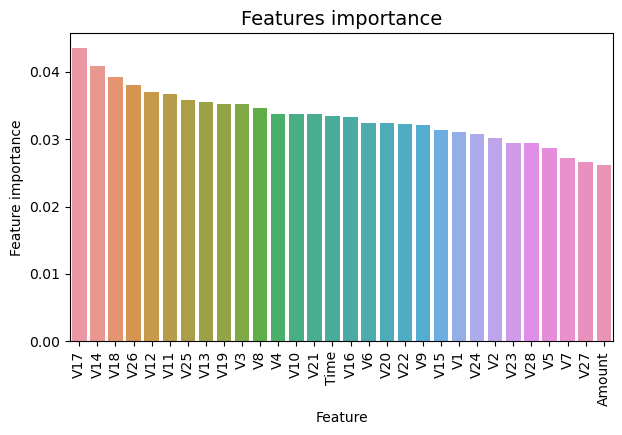

In [30]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

#### Confusion matrix

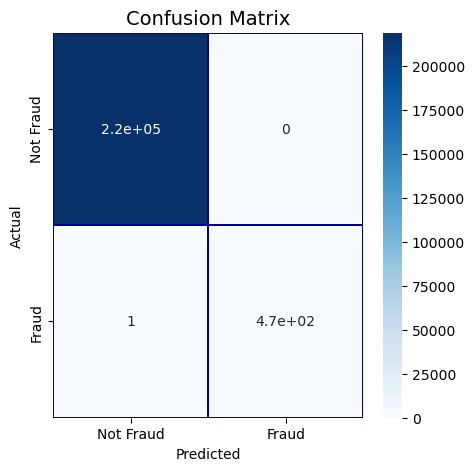

In [31]:
cm = pd.crosstab(df_train[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

#### Area under curve

In [32]:
roc_auc_score(df_train[target].values, preds)

0.9989339019189765

The ROC-AUC score obtained with RandomForrestClassifier is 0.99.